In [1]:
!pip install -qq llama-index llama-index-callbacks-arize-phoenix "openai>=1"  openai pyvis datasets pycm

In [2]:
# Standard library imports
import os
import re

# Third-party library imports
from getpass import getpass
from typing import Any, Dict, List, Optional, Set, Tuple, cast

import nest_asyncio
import pandas as pd
import phoenix as px

# Local module imports
from llama_index.core import SQLDatabase, set_global_handler
from llama_index.core.agent import (
    AgentChatResponse,
    AgentRunner,
    QueryPipelineAgentWorker,
    ReActChatFormatter,
    Task,
)
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.agent.react.types import (
    ObservationReasoningStep,
    ResponseReasoningStep,
)
from llama_index.core.callbacks import CallbackManager
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core.query_pipeline import (
    AgentFnComponent,
    AgentInputComponent,
    CustomAgentComponent,
    QueryComponent,
    QueryPipeline,
    ToolRunnerComponent,
)
from llama_index.core.tools import BaseTool, QueryEngineTool
from llama_index.llms.openai import OpenAI
from sqlalchemy import create_engine
from tqdm import tqdm

# Apply settings and initializations
pd.set_option("display.max_colwidth", 1000)
nest_asyncio.apply()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from phoenix.evals import (
    OpenAIModel,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

In [4]:
from phoenix.evals import SQL_GEN_EVAL_PROMPT_RAILS_MAP, SQL_GEN_EVAL_PROMPT_TEMPLATE

In [5]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [22]:
import os
import subprocess
import tempfile

temp_dir = tempfile.mkdtemp()
subprocess.run(
    [
        "curl",
        "https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip",
        "-o",
        os.path.join(temp_dir, "chinook.zip"),
    ],
    check=True,
)
subprocess.run(["unzip", "-o", os.path.join(temp_dir, "chinook.zip")], check=True)
engine = create_engine(f"sqlite:///{os.path.join(temp_dir, 'chinook.db')}")
sql_database = SQLDatabase(engine)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Archive:  /var/folders/xb/t60rdh1d4y3d37s881p75s1w0000gn/T/tmpu6v665g7/chinook.zip
  inflating: chinook.db              


100  298k  100  298k    0     0   481k      0 --:--:-- --:--:-- --:--:--  482k


In [14]:
session = px.launch_app()
set_global_handler("arize_phoenix")

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [15]:
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["albums", "tracks", "artists"],
    verbose=True,
)
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql_tool",
    description=("Useful for translating a natural language query into a SQL query"),
)

In [15]:
questions = [
    "What is the name of the artist with ID 5?",
    "List all tracks in the album with ID 3.",
    "How many tracks does the artist named 'Aerosmith' have?",
    "Find the oldest song in the database.",
    "What is the duration of the track with ID 10?",
    "List the names of all albums released in 2020.",
    "How many artists are in the database?",
    "Which artist has the most tracks in the database?",
    "List all tracks in the 'Pop' genre.",
    "What is the average length of tracks in the database?",
    "Find the most recent track.",
    "List the top 5 longest tracks in the database.",
    "Which album has the highest number of tracks?",
    "List all artists who have released more than 3 albums.",
    "What is the shortest track in the database?",
    "Find all albums released by 'The Beatles'.",
    "How many tracks are in the 'Rock' genre?",
    "List the names of all tracks released before 2000.",
    "What is the total duration of the album with ID 7?",
    "Find the artist who released the album 'Thriller'.",
    "List the names of all albums by 'Pink Floyd'.",
    "How many albums have been released between 1990 and 2000?",
    "What genres are covered by the artist 'David Bowie'?",
    "List the top 10 most played tracks.",
    "Which artist has the longest total track duration in the database?",
    "Find all tracks with a duration longer than 5 minutes.",
    "How many tracks does each album contain on average?",
    "List all albums sorted by release date.",
    "Which artist's albums have the highest average ratings?",
    "Find the total duration of all tracks by 'Michael Jackson'.",
    "How many tracks in the database are instrumental?",
    "List the names of all tracks by artists with the name starting with 'J'.",
    "What is the most common genre in the database?",
    "Find the average album length in minutes.",
    "How many artists have only one album in the database?",
    "List all tracks from the album with the most number of tracks.",
    "Which artist has released the most albums?",
    "Find the total number of tracks produced by 'Eminem'.",
    "How many albums in the database have no tracks?",
    "List the name and duration of the longest track in each album.",
    "What is the average number of tracks per album?",
    "Find all albums that have more than 10 tracks.",
    "How many tracks in the database are longer than the average track length?",
    "List the albums released by the artist with the most albums.",
    "Which year has the highest number of album releases?",
    "Find the total playtime of all tracks in the 'Jazz' genre.",
    "How many artists have names longer than 10 characters?",
    "List all song genres found in the database.",
    "What is the average track length of the tracks?",
    "How many albums were released on average by each artist?",
]

print(questions)

['What is the name of the artist with ID 5?', 'List all tracks in the album with ID 3.', "How many tracks does the artist named 'Aerosmith' have?", 'Find the oldest song in the database.', 'What is the duration of the track with ID 10?', 'List the names of all albums released in 2020.', 'How many artists are in the database?', 'Which artist has the most tracks in the database?', "List all tracks in the 'Pop' genre.", 'What is the average length of tracks in the database?', 'Find the most recent track.', 'List the top 5 longest tracks in the database.', 'Which album has the highest number of tracks?', 'List all artists who have released more than 3 albums.', 'What is the shortest track in the database?', "Find all albums released by 'The Beatles'.", "How many tracks are in the 'Rock' genre?", 'List the names of all tracks released before 2000.', 'What is the total duration of the album with ID 7?', "Find the artist who released the album 'Thriller'.", "List the names of all albums by 'P

In [16]:
## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.
def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

In [17]:
## define prompt function
def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(fn=react_prompt_fn, partial_dict={"tools": [sql_tool]})

In [20]:
## Agent Output Component
## Process reasoning step/tool outputs, and return agent response
def finalize_fn(
    task: Task,
    state: Dict[str, Any],
    reasoning_step: Any,
    is_done: bool = False,
    tool_output: Optional[Any] = None,
) -> Tuple[AgentChatResponse, bool]:
    """Finalize function.

    Here we take the latest reasoning step, and a tool output (if provided),
    and return the agent output (and decide if agent is done).

    This function returns an `AgentChatResponse` and `is_done` tuple. and
    is the last component of the query pipeline. This is the expected
    return type for any query pipeline passed to `QueryPipelineAgentWorker`.

    """
    current_reasoning = state["current_reasoning"]
    current_reasoning.append(reasoning_step)
    # if tool_output is not None, add to current reasoning
    if tool_output is not None:
        observation_step = ObservationReasoningStep(observation=str(tool_output))
        current_reasoning.append(observation_step)
    if isinstance(current_reasoning[-1], ResponseReasoningStep):
        response_step = cast(ResponseReasoningStep, current_reasoning[-1])
        response_str = response_step.response
    else:
        response_str = current_reasoning[-1].get_content()

    # if is_done, add to memory
    # NOTE: memory is a reserved keyword in `state`, but you can add your own too
    if is_done:
        state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
        state["memory"].put(ChatMessage(content=response_str, role=MessageRole.ASSISTANT))

    return AgentChatResponse(response=response_str), is_done


class OutputAgentComponent(CustomAgentComponent):
    """Output agent component."""

    tool_runner_component: ToolRunnerComponent
    output_parser: ReActOutputParser

    def __init__(self, tools, **kwargs):
        tool_runner_component = ToolRunnerComponent(tools)
        super().__init__(
            tool_runner_component=tool_runner_component, output_parser=ReActOutputParser(), **kwargs
        )

    def _run_component(self, **kwargs: Any) -> Any:
        """Run component."""
        chat_response = kwargs["chat_response"]
        task = kwargs["task"]
        state = kwargs["state"]
        reasoning_step = self.output_parser.parse(chat_response.message.content)
        if reasoning_step.is_done:
            return {"output": finalize_fn(task, state, reasoning_step, is_done=True)}
        else:
            tool_output = self.tool_runner_component.run_component(
                tool_name=reasoning_step.action,
                tool_input=reasoning_step.action_input,
            )
            return {
                "output": finalize_fn(
                    task,
                    state,
                    reasoning_step,
                    is_done=False,
                    tool_output=tool_output,
                )
            }

    @property
    def _input_keys(self) -> Set[str]:
        return {"chat_response"}

    @property
    def _optional_input_keys(self) -> Set[str]:
        return {"is_done", "tool_output"}

    @property
    def _output_keys(self) -> Set[str]:
        return {"output"}

    @property
    def sub_query_components(self) -> List[QueryComponent]:
        return [self.tool_runner_component]


react_output_component = OutputAgentComponent([sql_tool])

In [21]:
qp = QueryPipeline(
    modules={
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4-1106-preview"),
        "react_output": react_output_component,
    },
    verbose=True,
)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output"])

In [22]:
agent_worker = QueryPipelineAgentWorker(qp)
agent = AgentRunner(agent_worker, callback_manager=CallbackManager([]))
response = agent.chat("Is Aerosmith in this database?")
print(str(response))

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7503abaa-def5-45a4-8589-7154efe904ef' input='Is Aerosmith in this database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encodin...

> Running module react_prompt with input: 
input: Is Aerosmith in this database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question by checking if Aerosmith is in

In [25]:
all_sql_queries = []
all_ans = []
for question in tqdm(questions):
    agent_worker = QueryPipelineAgentWorker(qp)
    agent = AgentRunner(agent_worker, callback_manager=CallbackManager([]))
    task = agent.create_task(question)
    # Need to manually run the task as to recover the convo_history
    step_output = agent.run_step(task.task_id)
    ans = str(step_output)
    sql_query_match = re.search(r"\'sql_query\': \'([^\']+)\'", ans)

    if not sql_query_match:
        print(ans)
    # Extract the sql_query if the pattern is found
    sql_query = sql_query_match.group(1) if sql_query_match else None

    # Regular expression to extract the response
    response_match = re.search(r"response=\'([^\']+)\'", ans)

    # Extract the response if the pattern is found
    response = response_match.group(1) if response_match else None

    print("SQL Query:", sql_query)
    print("Response:", response)
    all_ans.append(response)
    all_sql_queries.append(sql_query)

  0%|          | 0/50 [00:00<?, ?it/s]

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='9f8df0ec-cf58-483e-bc47-5e59eea3574d' input='What is the name of the artist with ID 5?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode ...

> Running module react_prompt with input: 
input: What is the name of the artist with ID 5?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: sql_tool
A

  2%|▏         | 1/50 [00:03<02:52,  3.52s/it]

SQL Query: SELECT Name\nFROM artists\nWHERE ArtistId = 5;
Response: The artist with ID 5 is Alice In Chains.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='b15a2bb8-4e12-4459-8992-6fcb8857d111' input='List all tracks in the album with ID 3.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of...

> Running module react_prompt with input: 
input: List all tracks in the album with ID 3.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The curre

  4%|▍         | 2/50 [00:55<25:26, 31.79s/it]

SQL Query: SELECT Name, Composer \nFROM tracks \nWHERE AlbumId = 3
Response: The tracks in the album with ID 3 are "Fast As a Shark" composed by F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman, "Restless and Wild" composed by F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman, and "Princess of the Dawn" composed by Deaffy & R.A. Smith-Diesel.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='b969a4b0-d832-4af8-afb5-0a2eb78345a4' input="How many tracks does the artist named 'Aerosmith' have?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method En...

> Running module react_prompt with input: 
input: How many tracks does the artist named 'Aerosmith' have?

> Running module llm with input: 
messages: [ChatMessage(rol

  6%|▌         | 3/50 [00:59<14:59, 19.14s/it]

Observation: {'output': ToolOutput(content="The artist named 'Aerosmith' has a total of 15 tracks.", tool_name='sql_tool', raw_input={'input': "How many tracks does the artist named 'Aerosmith' have?"}, raw_output=Response(response="The artist named 'Aerosmith' has a total of 15 tracks.", source_nodes=[NodeWithScore(node=TextNode(id_='506c1f04-4f25-4557-97f2-35aad4b87eaf', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(15,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'506c1f04-4f25-4557-97f2-35aad4b87eaf': {}, 'sql_query': "SELECT COUNT(tracks.TrackId) AS NumTracks\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Aerosmith'", 'result': [(15,)], 'col_keys': ['NumTracks']}))}
SQL Query: None
Response: No

  8%|▊         | 4/50 [01:03<10:08, 13.22s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds ASC\nLIMIT 1;
Response: The oldest song in the database is "É Uma Partida De Futebol" with a duration of 1071 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='2daa960b-857e-4785-8963-33dd1da62fcf' input='What is the duration of the track with ID 10?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.enc...

> Running module react_prompt with input: 
input: What is the duration of the track with ID 10?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

 10%|█         | 5/50 [01:07<07:32, 10.06s/it]

SQL Query: SELECT Milliseconds\nFROM tracks\nWHERE TrackId = 10;
Response: The duration of the track with ID 10 is 263497 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='1e76a788-10e1-41cf-be5e-a3d1465c5620' input='List the names of all albums released in 2020.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with input: 
input: List the names of all albums released in 2020.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_respo

 12%|█▏        | 6/50 [01:12<06:01,  8.22s/it]

Observation: {'output': ToolOutput(content='There are no albums in the database that were released in 2020.', tool_name='sql_tool', raw_input={'input': 'List the names of all albums released in 2020'}, raw_output=Response(response='There are no albums in the database that were released in 2020.', source_nodes=[NodeWithScore(node=TextNode(id_='9a613f30-f765-465c-bb3b-774d1e227878', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'9a613f30-f765-465c-bb3b-774d1e227878': {}, 'sql_query': "SELECT Title\nFROM albums\nWHERE Title LIKE '%2020%'", 'result': [], 'col_keys': ['Title']}))}
SQL Query: None
Response: There are no albums in the database that were released in 2020.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatM

 14%|█▍        | 7/50 [01:16<05:00,  6.99s/it]

SQL Query: SELECT COUNT(ArtistId) AS TotalArtists FROM artists;
Response: There are a total of 275 artists in the database.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='91ef1198-3485-4b66-83fc-ba3d49feba3c' input='Which artist has the most tracks in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding...

> Running module react_prompt with input: 
input: Which artist has the most tracks in the database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assi

 16%|█▌        | 8/50 [01:20<04:14,  6.05s/it]

SQL Query: SELECT artists.Name, COUNT(tracks.TrackId) AS TrackCount\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY artists.ArtistId\nORDER BY TrackCount DESC\nLIMIT 1;
Response: The artist with the most tracks in the database is Iron Maiden, with a total of 213 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='016f066c-12f4-4a73-9f44-d97670646cc1' input="List all tracks in the 'Pop' genre." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <En...

> Running module react_prompt with input: 
input: List all tracks in the 'Pop' genre.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='

 18%|█▊        | 9/50 [02:14<14:11, 20.78s/it]

Observation: {'output': ToolOutput(content='Here is a list of tracks in the \'Pop\' genre: \'#9 Dream\', \'(There Is) No Greater Love (Teo Licks)\', \'Amy Amy Amy (Outro)\', \'Bate Lata\', \'Beautiful Boy\', \'Cold Turkey\', \'Daniela\', \'Dig-Dig, Lambe-Lambe (Ao Vivo)\', \'F**k Me Pumps\', \'Garotas do Brasil\', \'Gimme Some Truth\', \'Give Peace a Chance\', \'God\', \'Grow Old With Me\', \'Help Yourself\', \'I Heard Love Is Blind\', "I\'m Losing You", \'Imagine\', \'In My Bed\', \'Instant Karma\', \'Intro / Stronger Than Me\', \'Isolation\', \'Jealous Guy\', \'Latinha de Cerveja\', \'Lavadeira\', \'Levada do Amor (Ailoviu)\', \'Mother\', \'My Love\', \'Nobody Told Me\', \'October Song\', \'Oh, My Love\', \'Pererê\', \'Power to the People\', \'Real Love\', \'Reboladeira\', \'Reggae Tchan\', \'Take the Box\', \'Tapa Aqui, Descobre Ali\', \'TriboTchan\', \'Watching the Wheels\', \'What Is It About Men\', \'Whatever Gets You Thru the Night\', \'Working Class Hero\', \'You Sent Me Flying

 20%|██        | 10/50 [02:17<10:17, 15.43s/it]

SQL Query: SELECT AVG(Milliseconds) AS AverageLength\nFROM tracks
Response: The average length of tracks in the database is approximately 393,599 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='101ed056-1884-432a-a899-b4d5357934b9' input='Find the most recent track.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding '...

> Running module react_prompt with input: 
input: Find the most recent track.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...



 22%|██▏       | 11/50 [02:22<07:58, 12.27s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The user is asking for the most recent track, but I don't have any context or data source to determine what "track" refers to or where to find this information. I need to ask for c...

Could you please provide more context or specify the data source where I should look for the most recent track? Are you referring to a music track, a race track, or something else entirely?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='fb85319a-7698-40f4-961f-b372bedb75c3' input='List the top 5 longest tracks in the database.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with input: 
input: Li

 24%|██▍       | 12/50 [02:28<06:26, 10.16s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds DESC\nLIMIT 5;
Response: The top 5 longest tracks in the database are "Occupation / Precipice" with a length of 5286953 milliseconds, "Through a Looking Glass" with 5088838 milliseconds, "Greetings from Earth, Pt. 1" with 2960293 milliseconds, "The Man With Nine Lives" with 2956998 milliseconds, and "Battlestar Galactica, Pt. 2" with 2956081 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='26f991ff-14ca-4e8d-bdd9-e5b27abfcf3e' input='Which album has the highest number of tracks?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.enc...

> Running module react_prompt with input: 
input: Which album has the highest number of tracks?

> Runnin

 26%|██▌       | 13/50 [02:32<05:09,  8.37s/it]

SQL Query: SELECT Title AS album_name\nFROM albums\nORDER BY (SELECT COUNT(*) FROM tracks WHERE tracks.AlbumId = albums.AlbumId) DESC\nLIMIT 1
Response: The album with the most tracks is "Greatest Hits".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='a10c09b2-8651-4ba8-8507-1808fd7f737c' input='List all artists who have released more than 3 albums.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enc...

> Running module react_prompt with input: 
input: List all artists who have released more than 3 albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyse

 28%|██▊       | 14/50 [02:37<04:23,  7.31s/it]

SQL Query: SELECT artists.Name, COUNT(albums.AlbumId) AS AlbumCount\nFROM artists\nJOIN albums ON artists.ArtistId = albums.ArtistId\nGROUP BY artists.ArtistId\nHAVING COUNT(albums.AlbumId) > 3\nORDER BY AlbumCount DESC;
Response: Some of the artists who have released more than 3 albums include Iron Maiden with 21 albums, Led Zeppelin with 14 albums, Deep Purple with 11 albums, Metallica and U2 with 10 albums each, Ozzy Osbourne with 6 albums, and several others like Pearl Jam, Various Artists, Faith No More, Foo Fighters, Lost, and Van Halen with 4 albums each.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='2a55bea1-feb8-4607-8015-c3687025ac2c' input='What is the shortest track in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(

 30%|███       | 15/50 [02:41<03:46,  6.48s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nORDER BY Milliseconds\nLIMIT 1;
Response: The shortest track in the database is "É Uma Partida De Futebol" with a duration of 1071 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='0a7ad4e8-e222-433e-89df-a2fed283d72a' input="Find all albums released by 'The Beatles'." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode...

> Running module react_prompt with input: 
input: Find all albums released by 'The Beatles'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n..

 32%|███▏      | 16/50 [02:48<03:43,  6.57s/it]

Observation: {'output': ToolOutput(content="There are no albums in the database released by 'The Beatles'.", tool_name='sql_tool', raw_input={'input': "Find all albums released by 'The Beatles'."}, raw_output=Response(response="There are no albums in the database released by 'The Beatles'.", source_nodes=[NodeWithScore(node=TextNode(id_='0b880881-a81e-44ba-993d-ff734461f83f', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'0b880881-a81e-44ba-993d-ff734461f83f': {}, 'sql_query': "SELECT AlbumId, Title\nFROM albums\nWHERE ArtistId = (SELECT ArtistId FROM artists WHERE Name = 'The Beatles');", 'result': [], 'col_keys': ['AlbumId', 'Title']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory':

 34%|███▍      | 17/50 [02:53<03:18,  6.02s/it]

Observation: {'output': ToolOutput(content="There are 1297 tracks in the 'Rock' genre.", tool_name='sql_tool', raw_input={'input': "How many tracks are in the 'Rock' genre?"}, raw_output=Response(response="There are 1297 tracks in the 'Rock' genre.", source_nodes=[NodeWithScore(node=TextNode(id_='1bb52451-3127-4e9a-b012-f4fbbfde67cf', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(1297,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'1bb52451-3127-4e9a-b012-f4fbbfde67cf': {}, 'sql_query': "SELECT COUNT(*) \nFROM tracks \nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Rock');", 'result': [(1297,)], 'col_keys': ['COUNT(*)']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=f

 36%|███▌      | 18/50 [03:43<10:20, 19.41s/it]

SQL Query: SELECT Name\nFROM tracks\nWHERE Milliseconds < (SELECT Milliseconds FROM tracks WHERE Milliseconds = 2000)\nORDER BY Milliseconds DESC;
Response: There are no tracks in the database that were released before the year 2000.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='ca290783-2e9c-4bd5-84e8-cdf0e66cf2cc' input='What is the total duration of the album with ID 7?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodin...

> Running module react_prompt with input: 
input: What is the total duration of the album with ID 7?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries

 38%|███▊      | 19/50 [03:47<07:39, 14.81s/it]

SQL Query: SELECT SUM(Milliseconds) AS TotalDuration\nFROM tracks\nWHERE AlbumId = 7
Response: The total duration of the album with ID 7 is 3249365 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='f5ff8b22-cf53-4d29-8e91-aec749a9e23d' input="Find the artist who released the album 'Thriller'." memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodin...

> Running module react_prompt with input: 
input: Find the artist who released the album 'Thriller'.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_

 40%|████      | 20/50 [03:51<05:40, 11.36s/it]

Observation: {'output': ToolOutput(content="The artist who released the album 'Thriller' is Michael Jackson.", tool_name='sql_tool', raw_input={'input': "Find the artist who released the album 'Thriller'."}, raw_output=Response(response="The artist who released the album 'Thriller' is Michael Jackson.", source_nodes=[NodeWithScore(node=TextNode(id_='b9189f97-9f0a-4697-967d-5376ae898306', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'b9189f97-9f0a-4697-967d-5376ae898306': {}, 'sql_query': "SELECT ar.Name\nFROM artists ar\nJOIN albums al ON ar.ArtistId = al.ArtistId\nWHERE al.Title = 'Thriller';", 'result': [], 'col_keys': ['Name']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': Chat

 42%|████▏     | 21/50 [03:54<04:23,  9.08s/it]

Observation: {'output': ToolOutput(content="The album by Pink Floyd is 'Dark Side Of The Moon'.", tool_name='sql_tool', raw_input={'input': "List the names of all albums by 'Pink Floyd'."}, raw_output=Response(response="The album by Pink Floyd is 'Dark Side Of The Moon'.", source_nodes=[NodeWithScore(node=TextNode(id_='466c005c-65d7-448f-a0fd-ff3c581f0c27', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="[('Dark Side Of The Moon',)]", start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'466c005c-65d7-448f-a0fd-ff3c581f0c27': {}, 'sql_query': "SELECT albums.Title\nFROM albums\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Pink Floyd';", 'result': [('Dark Side Of The Moon',)], 'col_keys': ['Title']}))}
SQL Query: None
Response: None
> Running module agent_input with input: 
s

 44%|████▍     | 22/50 [03:58<03:27,  7.42s/it]

Observation: {'output': ToolOutput(content='There were 0 albums released between 1990 and 2000 according to the database query results.', tool_name='sql_tool', raw_input={'input': 'How many albums have been released between 1990 and 2000?'}, raw_output=Response(response='There were 0 albums released between 1990 and 2000 according to the database query results.', source_nodes=[NodeWithScore(node=TextNode(id_='bc0dee60-f470-4983-9e9b-b47920079462', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'bc0dee60-f470-4983-9e9b-b47920079462': {}, 'sql_query': "SELECT COUNT(AlbumId) \nFROM albums \nWHERE Title BETWEEN '1990-01-01' AND '2000-12-31'", 'result': [(0,)], 'col_keys': ['COUNT(AlbumId)']}))}
SQL Query: None
Response: There were 0 albums rele

 46%|████▌     | 23/50 [04:03<03:00,  6.68s/it]

Observation: {'output': ToolOutput(content='David Bowie covered a wide range of genres in his music, including rock, pop, electronic, and experimental.', tool_name='sql_tool', raw_input={'input': "What genres are covered by the artist 'David Bowie'?"}, raw_output=Response(response='David Bowie covered a wide range of genres in his music, including rock, pop, electronic, and experimental.', source_nodes=[NodeWithScore(node=TextNode(id_='681dd9e7-3740-4317-970a-7e4a7875f474', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'681dd9e7-3740-4317-970a-7e4a7875f474': {}, 'sql_query': "SELECT DISTINCT g.Name\nFROM genres g\nJOIN tracks t ON g.GenreId = t.GenreId\nJOIN albums a ON t.AlbumId = a.AlbumId\nJOIN artists ar ON a.ArtistId = ar.ArtistId\nWHERE 

 48%|████▊     | 24/50 [04:09<02:47,  6.43s/it]

SQL Query: SQL Query to run: \nSELECT tracks.Name, COUNT(tracks.TrackId) AS PlayCount\nFROM tracks\nJOIN invoice_items ON tracks.TrackId = invoice_items.TrackId\nGROUP BY tracks.TrackId\nORDER BY PlayCount DESC\nLIMIT 10;
Response: It seems there was an error in running the SQL query to list the top 10 most played tracks. Please check the syntax and try running the query again to get the desired results.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='b0b927a3-a3a8-4b1e-8c6e-2d4c76ff4570' input='Which artist has the longest total track duration in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<boun...

> Running module react_prompt with input: 
input: Which artist has the longest total track duration in the database?

> Running 

 50%|█████     | 25/50 [04:13<02:25,  5.81s/it]

SQL Query: SELECT ar.Name AS ArtistName, SUM(tr.Milliseconds) AS TotalDuration\nFROM artists ar\nJOIN albums al ON ar.ArtistId = al.ArtistId\nJOIN tracks tr ON al.AlbumId = tr.AlbumId\nGROUP BY ar.ArtistId\nORDER BY TotalDuration DESC\nLIMIT 1;
Response: The artist with the longest total track duration in the database is Lost, with a total duration of 238,278,582 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='d6b45ce3-a9d0-4593-ab2a-b49187885b08' input='Find all tracks with a duration longer than 5 minutes.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enc...

> Running module react_prompt with input: 
input: Find all tracks with a duration longer than 5 minutes.

> Running module llm with input: 
messages: [ChatM

 52%|█████▏    | 26/50 [04:32<03:56,  9.85s/it]

SQL Query: SELECT Name, Milliseconds\nFROM tracks\nWHERE Milliseconds > 300000\nORDER BY Milliseconds DESC;
Response: Unfortunately, there are no tracks with a duration longer than 5 minutes in the provided list.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='f07800d3-0c2e-40a7-a015-5524cc9529c9' input='How many tracks does each album contain on average?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encodi...

> Running module react_prompt with input: 
input: How many tracks does each album contain on average?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of a

 54%|█████▍    | 27/50 [04:36<03:04,  8.02s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer this question, I need more information about the database schema and the data. If I had the schema, I could construct a SQL q...

To provide an accurate answer, I need to know the structure of the database we are querying. Could you please provide the database schema or the relevant table structures, including the names of the tables and the columns that store information about albums and tracks?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='c19bf312-def1-4d64-8f12-7caac44a5d50' input='List all albums sorted by release date.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound me

 56%|█████▌    | 28/50 [04:40<02:28,  6.74s/it]

SQL Query: SELECT AlbumId, Title\nFROM albums\nORDER BY ReleaseDate;
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='09546dd9-4674-4e25-ab8d-9ee03f33cfce' input="Which artist's albums have the highest average ratings?" memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method En...

> Running module react_prompt with input: 
input: Which artist's albums have the highest average ratings?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...



 58%|█████▊    | 29/50 [04:45<02:08,  6.14s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer this question, I need more context or data about the albums and their ratings. If this is a database query, I would need to k...

To assist you with finding out which artist's albums have the highest average ratings, I would need more information about the data you are referring to. Are you querying a specific database? If so, could you provide the structure of the database, particularly the tables and fields that contain the artist names and album ratings?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='30503520-77d2-40d4-8dd9-f4a15b275c8b' input="Find the total duration of all tracks by 'Michael Jackson'." 

 60%|██████    | 30/50 [04:50<01:57,  5.89s/it]

Observation: {'output': ToolOutput(content="There seems to be an error in the SQL query provided. The correct query to find the total duration of all tracks by 'Michael Jackson' would be:\n\nSELECT SUM(tracks.Milliseconds) AS TotalDuration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Michael Jackson'\n\nThis query will sum up the duration of all tracks by 'Michael Jackson' and provide the total duration in milliseconds.", tool_name='sql_tool', raw_input={'input': "Find the total duration of all tracks by 'Michael Jackson'."}, raw_output=Response(response="There seems to be an error in the SQL query provided. The correct query to find the total duration of all tracks by 'Michael Jackson' would be:\n\nSELECT SUM(tracks.Milliseconds) AS TotalDuration\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Michael Jackson

 62%|██████▏   | 31/50 [04:54<01:39,  5.25s/it]

Observation: {'output': ToolOutput(content='There are 0 instrumental tracks in the database.', tool_name='sql_tool', raw_input={'input': 'How many tracks in the database are instrumental?'}, raw_output=Response(response='There are 0 instrumental tracks in the database.', source_nodes=[NodeWithScore(node=TextNode(id_='56255223-cfac-414e-b25a-81b7e8110b7f', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'56255223-cfac-414e-b25a-81b7e8110b7f': {}, 'sql_query': "SELECT COUNT(*) \nFROM tracks \nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Instrumental');", 'result': [(0,)], 'col_keys': ['COUNT(*)']}))}
SQL Query: None
Response: There are 0 instrumental tracks in the database.
> Running module agent_input with input: 
state: {'source

 64%|██████▍   | 32/50 [05:02<01:52,  6.26s/it]

Observation: {'output': ToolOutput(content='Some of the tracks by artists with names starting with \'J\' include "Last Chance", "Are You Gonna Be My Girl", "Rollover D.J.", "Look What You\'ve Done", "Get What You Need", "Move On", "Radio Song", "Get Me Outta Here", "Cold Hard Bitch", and many more.', tool_name='sql_tool', raw_input={'input': "List the names of all tracks by artists with the name starting with 'J'."}, raw_output=Response(response='Some of the tracks by artists with names starting with \'J\' include "Last Chance", "Are You Gonna Be My Girl", "Rollover D.J.", "Look What You\'ve Done", "Get What You Need", "Move On", "Radio Song", "Get Me Outta Here", "Cold Hard Bitch", and many more.', source_nodes=[NodeWithScore(node=TextNode(id_='c97792b6-0c52-461b-b27f-ab901cc4ad24', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(\'Last Chance\',), (\'Are You Gonna Be My Girl\',), (\'Rollover D.J.\',), ("Look What 

 66%|██████▌   | 33/50 [05:08<01:43,  6.08s/it]

SQL Query: SELECT genres.Name AS Genre, COUNT(tracks.GenreId) AS NumTracks\nFROM tracks\nJOIN genres ON tracks.GenreId = genres.GenreId\nGROUP BY tracks.GenreId\nORDER BY NumTracks DESC\nLIMIT 1;
Response: The most common genre in the database is Rock, with a total of 1297 tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='bcc499ae-d6b7-4b45-9050-94b564e81c65' input='Find the average album length in minutes.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode ...

> Running module react_prompt with input: 
input: Find the average album length in minutes.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from ans

 68%|██████▊   | 34/50 [05:13<01:29,  5.60s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To provide an answer, I need more context or data about the albums. If there is a database with album information, I would need to know...

To assist you with finding the average album length in minutes, I would need access to the relevant data. Could you please provide the database or the necessary details about the albums you are referring to?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='030c7e90-adfe-4bc0-b048-75961adb1587' input='How many artists have only one album in the database?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Enco...

> Running module react_prompt with

 70%|███████   | 35/50 [05:17<01:19,  5.30s/it]

SQL Query: SELECT COUNT(*) AS NumArtists\nFROM (\n    SELECT ArtistId, COUNT(AlbumId) AS NumAlbums\n    FROM albums\n    GROUP BY ArtistId\n    HAVING NumAlbums = 1\n) AS Subquery;
Response: There are 148 artists in the database who have only one album.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='2e8629af-5755-441d-bac8-1ef28fe6a18b' input='List all tracks from the album with the most number of tracks.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound me...

> Running module react_prompt with input: 
input: List all tracks from the album with the most number of tracks.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering 

 72%|███████▏  | 36/50 [05:22<01:11,  5.07s/it]

SQL Query: SELECT t.Name, a.Title\nFROM tracks t\nJOIN albums a ON t.AlbumId = a.AlbumId\nGROUP BY a.AlbumId\nORDER BY COUNT(t.TrackId) DESC\nLIMIT 1;
Response: The album with the most number of tracks is "Greatest Hits," and one of the tracks from that album is "Are You Gonna Go My Way."
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='f087e3d7-993e-48c9-a92e-7924adcbce96' input='Which artist has released the most albums?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode...

> Running module react_prompt with input: 
input: Which artist has released the most albums?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks,

 74%|███████▍  | 37/50 [05:27<01:08,  5.30s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: To answer this question, I would need access to a comprehensive music database, which I do not have. However, I can provide a general answer based on common knowledge up to my last...

It is difficult to determine which artist has released the most albums without access to a current and comprehensive music database. However, as of my last update, artists such as Frank Zappa and The Rolling Stones are known for having extensive discographies. In the realm of classical music, composers like Johann Sebastian Bach and Wolfgang Amadeus Mozart have a vast number of compositions, many of which have been recorded multiple times by various artists. For the most accurate and up-to-date information, it would be best to consult a music database or resource that tracks artist discographies.
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limi

 76%|███████▌  | 38/50 [05:32<00:59,  4.99s/it]

Observation: {'output': ToolOutput(content='Eminem has produced a total of 0 tracks.', tool_name='sql_tool', raw_input={'input': "Find the total number of tracks produced by 'Eminem'."}, raw_output=Response(response='Eminem has produced a total of 0 tracks.', source_nodes=[NodeWithScore(node=TextNode(id_='b0021ac7-dced-461f-ae36-7b66e3c0f2e6', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(0,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'b0021ac7-dced-461f-ae36-7b66e3c0f2e6': {}, 'sql_query': "SELECT COUNT(tracks.TrackId) AS TotalTracks\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Eminem'", 'result': [(0,)], 'col_keys': ['TotalTracks']}))}
SQL Query: None
Response: Eminem has produced a total of 0 

 78%|███████▊  | 39/50 [05:35<00:49,  4.50s/it]

SQL Query: SELECT COUNT(*) AS NumAlbumsNoTracks\nFROM albums\nWHERE AlbumId NOT IN (SELECT DISTINCT AlbumId FROM tracks);
Response: There are no albums in the database that have no tracks.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='5eec4dea-7475-4470-8516-7bd79b24d06b' input='List the name and duration of the longest track in each album.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound me...

> Running module react_prompt with input: 
input: List the name and duration of the longest track in each album.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n#

 80%|████████  | 40/50 [07:34<06:28, 38.89s/it]

SQL Query: SELECT a.Title AS AlbumTitle, t.Name AS TrackName, MAX(t.Milliseconds) AS Duration\nFROM albums a\nJOIN tracks t ON a.AlbumId = t.AlbumId\nGROUP BY a.AlbumId
Response: The longest track in each album is as follows:\n- Rotten Apples: Greatest Hits: Rhinocerous - 353462 milliseconds\n- A-Sides: Hands All Over - 362475 milliseconds\n- Morning Dance: Heliopolis - 338729 milliseconds\n- In Step: Riviera Paradise - 528692 milliseconds\n- Górecki: Symphony No. 3: Symphony No. 3 Op. 36 for Orchestra and Soprano "Symfonia Piesni Zalosnych" \\\\ Lento E Largo - Tranquillissimo - 567494 milliseconds
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='a4b00277-7dfc-4556-874c-3aff9440e93d' input='What is the average number of tracks per album?' memory=ChatMemoryBuffer(token_l

 82%|████████▏ | 41/50 [07:38<04:13, 28.22s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer this question, I need to know the context or have access to a database from which to extract this information. Since I don't ...

To provide an accurate answer, I would need access to the specific database or dataset that contains information about albums and tracks. Could you please provide more details or the database information?
SQL Query: None
Response: None
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='e0a716e2-eb10-4117-bcd7-c88df3dad63e' input='Find all albums that have more than 10 tracks.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.en...

> Running module react_prompt with in

 84%|████████▍ | 42/50 [07:45<02:56, 22.05s/it]

SQL Query: SELECT albums.AlbumId, albums.Title, COUNT(tracks.TrackId) AS TrackCount\nFROM albums\nJOIN tracks ON albums.AlbumId = tracks.AlbumId\nGROUP BY albums.AlbumId\nHAVING TrackCount > 10\nORDER BY TrackCount DESC;
Response: Here are some albums that have more than 10 tracks: \n1. Greatest Hits - 57 tracks\n2. Minha Historia - 34 tracks\n3. Unplugged - 30 tracks\n4. Lost, Season 3 - 26 tracks\n5. Lost, Season 1 - 25 tracks\n6. The Office, Season 3 - 25 tracks\n7. My Way: The Best Of Frank Sinatra [Disc 1] - 24 tracks\n8. Lost, Season 2 - 24 tracks\n9. Battlestar Galactica (Classic), Season 1 - 24 tracks\n10. And many more.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='c1bf80b3-88ba-41e4-ab58-63f1839432a8' input='How many tracks in the database are longer than th

 86%|████████▌ | 43/50 [07:49<01:54, 16.42s/it]

SQL Query: SELECT COUNT(*) AS NumTracks\nFROM tracks\nWHERE Milliseconds > (SELECT AVG(Milliseconds) FROM tracks)
Response: There are 494 tracks in the database that are longer than the average track length.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='558214a2-3a84-4598-8b9a-7a549951aed6' input='List the albums released by the artist with the most albums.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound meth...

> Running module react_prompt with input: 
input: List the albums released by the artist with the most albums.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types 

 88%|████████▊ | 44/50 [07:53<01:16, 12.74s/it]

SQL Query: SELECT Name AS artist_name\nFROM artists\nORDER BY (SELECT COUNT(AlbumId) FROM albums WHERE ArtistId = artists.ArtistId) DESC\nLIMIT 1
Response: The artist with the most albums is Iron Maiden.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='7b9b1929-50c9-467b-b239-d843d11d2517' input='Which year has the highest number of album releases?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encod...

> Running module react_prompt with input: 
input: Which year has the highest number of album releases?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.

 90%|█████████ | 45/50 [07:57<00:50, 10.16s/it]

Observation: {'output': ToolOutput(content='The year with the highest number of album releases is not specified in the query results.', tool_name='sql_tool', raw_input={'input': 'Which year has the highest number of album releases?'}, raw_output=Response(response='The year with the highest number of album releases is not specified in the query results.', source_nodes=[NodeWithScore(node=TextNode(id_='539743ff-8b18-40a5-9009-84a70c37fd5c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(None, 347)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'539743ff-8b18-40a5-9009-84a70c37fd5c': {}, 'sql_query': "SELECT strftime('%Y', albums.Title) AS Year, COUNT(*) AS NumAlbums\nFROM albums\nGROUP BY Year\nORDER BY NumAlbums DESC\nLIMIT 1;", 'result': [(None, 347)], 'col_keys': ['Year', 'NumAlbums']}))}


 92%|█████████▏| 46/50 [08:00<00:32,  8.19s/it]

Observation: {'output': ToolOutput(content="The total playtime of all tracks in the 'Jazz' genre is 37,928,199 milliseconds.", tool_name='sql_tool', raw_input={'input': "Find the total playtime of all tracks in the 'Jazz' genre."}, raw_output=Response(response="The total playtime of all tracks in the 'Jazz' genre is 37,928,199 milliseconds.", source_nodes=[NodeWithScore(node=TextNode(id_='42bc1753-a010-4027-aa6b-79e09da1a948', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(37928199,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'42bc1753-a010-4027-aa6b-79e09da1a948': {}, 'sql_query': "SELECT SUM(Milliseconds) AS TotalPlaytime\nFROM tracks\nWHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Jazz')", 'result': [(37928199,)], 'col_keys': ['TotalPlaytime']}))}
SQL Query: None
Response:

 94%|█████████▍| 47/50 [08:03<00:19,  6.64s/it]

SQL Query: SELECT COUNT(ArtistId) \nFROM artists \nWHERE LENGTH(Name) > 10
Response: There are 201 artists with names longer than 10 characters.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='51115ac5-c8b1-4719-a465-3207c8ca980a' input='List all song genres found in the database.' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encod...

> Running module react_prompt with input: 
input: List all song genres found in the database.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat

 96%|█████████▌| 48/50 [08:08<00:12,  6.11s/it]

SQL Query: SELECT DISTINCT Name\nFROM genres
Response: The song genres found in the database include Rock, Jazz, Metal, Alternative & Punk, Rock And Roll, Blues, Latin, Reggae, Pop, Soundtrack, Bossa Nova, Easy Listening, Heavy Metal, R&B/Soul, Electronica/Dance, World, Hip Hop/Rap, Science Fiction, TV Shows, Sci Fi & Fantasy, Drama, Comedy, Alternative, Classical, and Opera.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='6b836c39-af15-4e1f-a283-81cb3abf6d87' input='What is the average track length of the tracks?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.e...

> Running module react_prompt with input: 
input: What is the average track length of the tracks?

> Running module llm with input: 
messages: [ChatMessage(r

 98%|█████████▊| 49/50 [08:13<00:05,  5.72s/it]

SQL Query: SELECT AVG(Milliseconds) AS AverageTrackLength FROM tracks
Response: The average track length of the tracks is approximately 393,599 milliseconds.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='4bd70b9d-f39a-49cd-b6a6-f584721ed937' input='How many albums were released on average by each artist?' memory=ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method E...

> Running module react_prompt with input: 
input: How many albums were released on average by each artist?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...



100%|██████████| 50/50 [08:28<00:00, 10.18s/it]

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. To answer the question, I need more context or data about the albums and artists. Since I don't have access to a specific database or d...

To calculate the average number of albums released by each artist, you would need a dataset that includes information about artists and their albums. If you have such a dataset, you could use the following approach:

1. Count the total number of albums for each artist.
2. Count the total number of unique artists.
3. Divide the total number of albums by the total number of artists to get the average number of albums per artist.

If you have a database, this could typically be done with a SQL query. If you can provide the dataset or more context, I could assist you further in calculating the average.
SQL Query: None
Response: None


In [26]:
df = pd.DataFrame({"question": questions, "query_gen": all_sql_queries, "response": all_ans})
df[:3]

,question,query_gen,response
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.
1,List all tracks in the album with ID 3.,"SELECT Name, Composer \nFROM tracks \nWHERE AlbumId = 3","The tracks in the album with ID 3 are ""Fast As a Shark"" composed by F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman, ""Restless and Wild"" composed by F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman, and ""Princess of the Dawn"" composed by Deaffy & R.A. Smith-Diesel."
2,How many tracks does the artist named 'Aerosmith' have?,None,None


In [29]:
print(SQL_GEN_EVAL_PROMPT_TEMPLATE)


SQL Evaluation Prompt:
TEST EDIT 
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided instruction.

- [Provided Response]: {response}
  This is the response and/or conclusions made after running the sql query through the database

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query 

In [30]:
df.rename(columns={"query": "question", "sql_query": "query_gen"}, inplace=True)

In [31]:
rails = list(SQL_GEN_EVAL_PROMPT_RAILS_MAP.values())
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)
relevance_classifications = llm_classify(
    dataframe=df,
    template=SQL_GEN_EVAL_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
)
# relevance_classifications

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:14<00:00 |  3.50it/s


In [32]:
labels = relevance_classifications["label"].tolist()
explanation = relevance_classifications["explanation"].tolist()

In [33]:
df["label"] = labels
df["explanation"] = explanation

In [34]:
df[:2]

,question,query_gen,response,label,explanation
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.,correct,The SQL query is selecting the 'Name' from the 'artists' table where the 'ArtistId' is equal to 5. This matches the instruction to find the name of the artist with ID 5. The provided response also indicates that the query has been executed correctly and returned the expected result.
1,List all tracks in the album with ID 3.,"SELECT Name, Composer \nFROM tracks \nWHERE AlbumId = 3","The tracks in the album with ID 3 are ""Fast As a Shark"" composed by F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman, ""Restless and Wild"" composed by F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman, and ""Princess of the Dawn"" composed by Deaffy & R.A. Smith-Diesel.",correct,"The instruction asks for all tracks in the album with ID 3. The SQL query correctly selects the Name and Composer from the 'tracks' table where the AlbumId is 3. The provided response lists the tracks and their composers, which matches the information requested in the instruction. Therefore, the SQL query correctly solves the instruction."


In [35]:
boolean_classifications = [x == "correct" for x in df["label"].tolist()]

In [36]:
df["is_correct"] = boolean_classifications

In [37]:
df["ground_truth"] = [
    True,
    True,
    False,
    False,
    True,
    False,
    True,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    False,
    True,
    False,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    True,
    False,
    True,
    False,
]
true_labels = df["ground_truth"]

              precision    recall  f1-score   support

        True       0.95      0.71      0.82        28
       False       0.72      0.95      0.82        22

    accuracy                           0.82        50
   macro avg       0.84      0.83      0.82        50
weighted avg       0.85      0.82      0.82        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

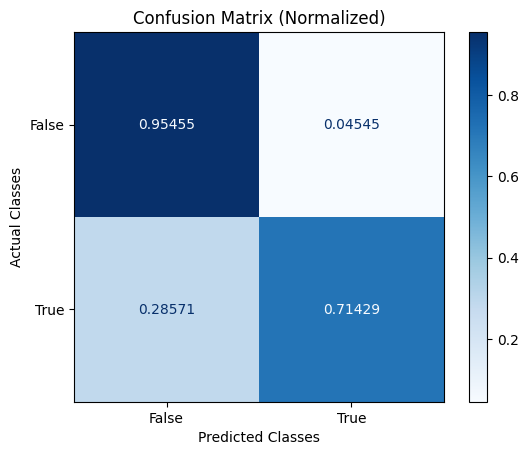

In [38]:
print(classification_report(true_labels, boolean_classifications, labels=[True, False]))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels.tolist(), predict_vector=boolean_classifications
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)